In [1]:
import argparse
import math
import json
import numpy as np
import os
import torch
import glob, time
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display
from utils.dsp import load_wav
from utils.world import world_split, world_join, logsp_norm, logsp_unnorm
from resemblyzer import VoiceEncoder, preprocess_wav

from dataset_world import AudiobookDataset

from hparams import hparams as hp
from model_vc_worldx2 import Generator
from synthesis import build_model
from synthesis import wavegen

In [2]:
speaker = 'p226'
tgt_speaker = 'p230'
filename = f'{speaker}_336'

device = torch.device('cpu')

src_wav_path = f'./data/test/{speaker}/{filename}/0000.wav'
src_emb_path = f'./data/test/{speaker}/emb.npy'
tgt_emb_path = f'./data/test/{tgt_speaker}/emb.npy'
src_wav_gpath = f'./data/test/{speaker}/*/*.wav'
tgt_wav_gpath = f'./data/test/{tgt_speaker}/*/*.wav'
autovc_checkpoint_path = 'checkpoints/checkpoint_x2_step000600.pth'

In [3]:
def getConvertInfo(wav_gpath):
    encoder = VoiceEncoder()
    wave = []
    embed = []
    for path in glob.glob(wav_gpath):
        wav = load_wav(path)
        wave.append(wav)
        embed.append(encoder.embed_utterance(wav))
    wave = np.array(wav).flatten()
    f0, t, sp = world_split(wave, use_ap=False)
    logf0 = np.log(f0[np.nonzero(f0)])
    f0_logmean = logf0.mean()
    f0_logstd = logf0.std()
    embed = np.array(embed).mean(axis=0)
    return embed, f0_logmean, f0_logstd
src_embed, src_f0_logmean, src_f0_logstd = getConvertInfo(src_wav_gpath)
tgt_embed, tgt_f0_logmean, tgt_f0_logstd = getConvertInfo(tgt_wav_gpath)

Loaded the voice encoder model on cpu in 0.02 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.


In [4]:
t1 = time.time()
wav = load_wav(src_wav_path)
wav = wav[hp.sample_rate:(256*20-1)*4+hp.sample_rate]
emb = np.load(src_emb_path)
emb_tgt = np.load(tgt_emb_path)

f0, t, sp_in, ap = world_split(wav)
sp = sp_in.reshape((-1, 64, 513))
sp = logsp_norm(np.log(sp))
sembs = np.array([ emb for _ in range(sp.shape[0])])
tembs = np.array([ emb_tgt for _ in range(sp.shape[0])])

mels = torch.from_numpy(sp.astype(np.float32)).clone()
sembs = torch.from_numpy(sembs.astype(np.float32)).clone()
tembs = torch.from_numpy(tembs.astype(np.float32)).clone()

print(mels.shape, sembs.shape, tembs.shape)

torch.Size([4, 64, 513]) torch.Size([4, 256]) torch.Size([4, 256])


In [5]:
model = Generator(hp.dim_neck, hp.dim_emb, hp.dim_pre, hp.freq).to(device)
checkpoint = torch.load(autovc_checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
model.eval()

Generator(
  (style_encoder): StyleEncoder(
    (lstm): LSTM(513, 768, num_layers=2, batch_first=True)
    (linear): LinearNorm(
      (linear_layer): Linear(in_features=768, out_features=256, bias=True)
    )
  )
  (encoder): ContentEncoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(769, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
   

In [6]:
with torch.no_grad():
    m = mels.to(device)
    se = sembs.to(device)
    te = tembs.to(device)
    mel_outputs, mel_outputs_postnet, codes = model(m, se, te)

In [7]:
sp_out = np.exp(logsp_unnorm(mel_outputs.to('cpu').detach().numpy().copy()))
sp_out = sp_out.reshape((-1, 513)).astype(np.double)
f0_out = np.exp( (np.ma.log(f0).data - src_f0_logmean ) / src_f0_logstd * tgt_f0_logstd + tgt_f0_logmean )
f0_out[f0==0] = 0
wav_out = world_join(f0_out, sp_out, ap)
print()
print(time.time()-t1)

5.906086206436157


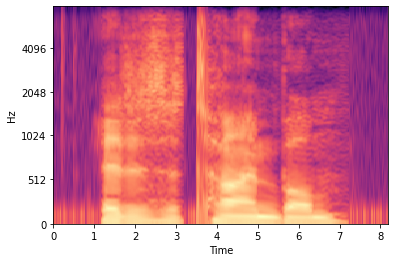

In [8]:
librosa.display.specshow(np.log(sp_in).T, x_axis='time', y_axis='mel', sr=16000)

Text(0, 0.5, 'Time')

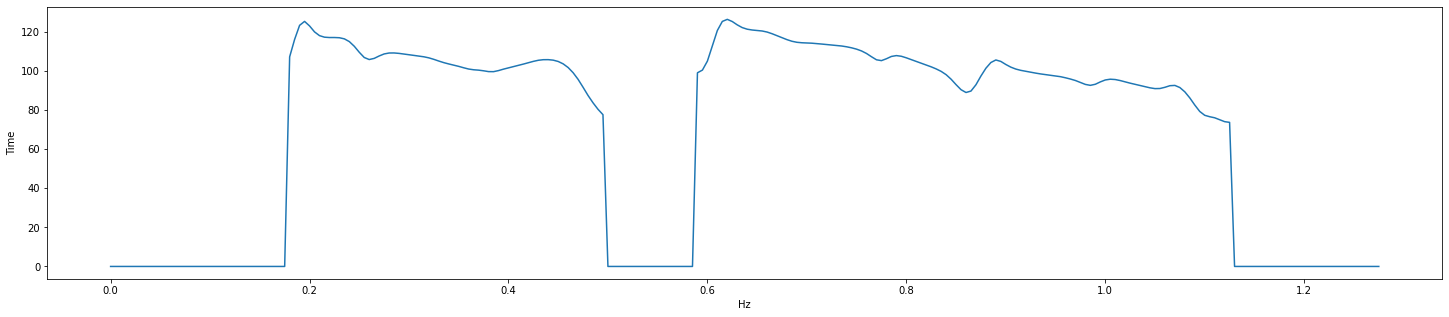

In [9]:
plt.figure(figsize=(25,5))
plt.plot(t, f0)
plt.xlabel('Hz')
plt.ylabel('Time')

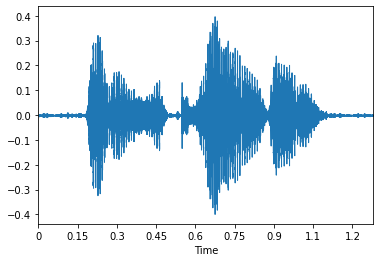

In [10]:
librosa.display.waveplot(wav, sr=16000)

In [11]:
IPython.display.Audio(wav, rate=16000)

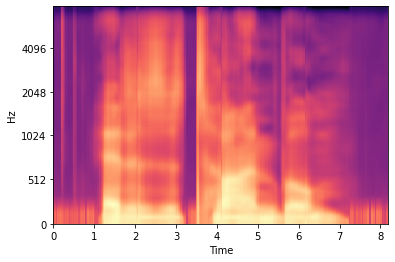

In [12]:
librosa.display.specshow(np.log(sp_out).T, x_axis='time', y_axis='mel', sr=16000)

Text(0, 0.5, 'Time')

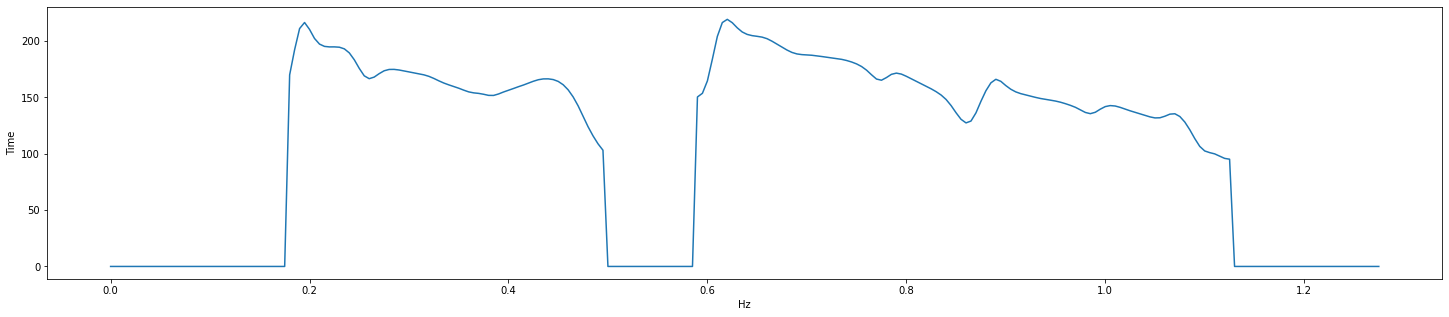

In [13]:
plt.figure(figsize=(25,5))
plt.plot(t, f0_out)
plt.xlabel('Hz')
plt.ylabel('Time')

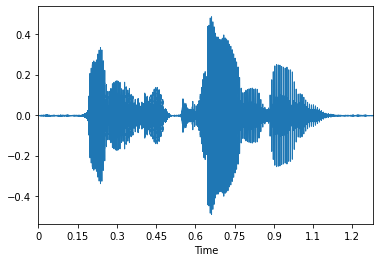

In [14]:
librosa.display.waveplot(wav_out, sr=16000)

In [15]:
IPython.display.Audio(wav_out, rate=16000)